In [1]:
import numpy as np
import xarray as xr
import zarr
from pyTMD.interpolate import spline, extrapolate
from datetime import datetime
import netCDF4
import importlib, sys

In [2]:
# Unload the module
if 'model_utils' in sys.modules:
    del sys.modules['model_utils']

# Reload the module
import src.model_utils
# Now you can use the reloaded function
from src.model_utils import *

In [4]:
if 'model_plot' in sys.modules:
    del sys.modules['model_plot']

import src.model_plot
from src.model_plot import *

In [5]:
#Some internal modules in pyTMD to be used here
if 'pytmd_utils' in sys.modules:
    del sys.modules['pytmd_utils']

import src.pytmd_utils
from src.pytmd_utils import *

In [6]:
# Model parameters
tpxo_model_directory = '/home/bioer/python/tide/data_src'
tpxo_model_format = 'netcdf'
tpxo_compressed = False
tpxo_model_name = 'TPXO9-atlas-v5'
tpxo9_atlas_v5 = get_tide_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)
print(tpxo9_atlas_v5.grid_file)

/home/bioer/python/tide/data_src/TPXO9_atlas_v5/grid_tpxo9_atlas_30_v5.nc


In [7]:
#if tpxo9_atlas_v5:
model_files= tpxo9_atlas_v5.model_file
#print(model_files)
#for i, model_file in enumerate(model_files):
model_file = pathlib.Path(model_files[7]).expanduser()
#model_file = pathlib.Path(model_file).expanduser()
hcz, cons = read_netcdf_elevation(model_file, compressed=False)
#print(hcz.mask.shape)
print(np.where(hcz.mask))

(array([], dtype=int64), array([], dtype=int64))


(array([   0,    0,    0, ..., 5211, 5211, 5211]), array([   0,    1,    2, ..., 9518, 9519, 9520]))


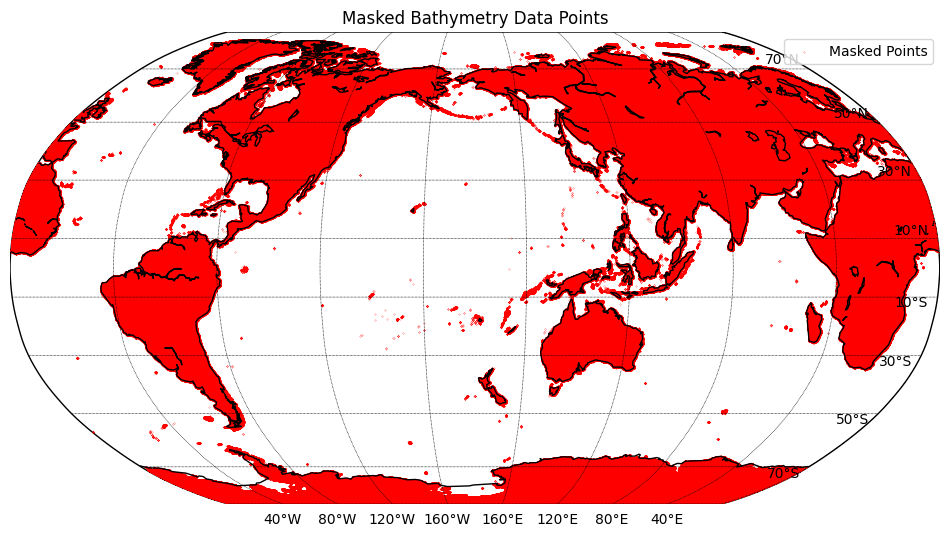

In [666]:
#Check model file NA value location
tmp_mask = np.copy(hcz.mask)
tmp_mask[hcz.data==0j] = True
print(np.where(tmp_mask))
plot_model_mask(tmp_mask)

In [8]:
#read_netcdf_grid in ATLAS.py
fileID = netCDF4.Dataset(tpxo9_atlas_v5.grid_file, 'r')
# read latitude and longitude at z-nodes
lonz = fileID.variables['lon_z'][:].copy()
latz = fileID.variables['lat_z'][:].copy()
print(lonz)
print(latz)
print(lonz.shape)
print(latz.shape)
nx = fileID.dimensions['nx'].size
ny = fileID.dimensions['ny'].size
print(ny, nx)

[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]
(10800,)
(5401,)
5401 10800


In [9]:
bathy_z = np.ma.zeros((ny,nx))
bathy_z.data[:,:] = fileID.variables['hz'][:,:].T
bathy_z.mask = (bathy_z.data == 0.0)


In [82]:
def extract_ATLAS(lon, lat, start_lon, end_lon, start_lat, end_lat, bathymetry, 
                  tide_model, type=None, global_grid=False, 
                  en_interpolate=False, interpolate_to=None):
    if type in ['u', 'v']:
        model_files= tide_model.model_file[type]
    else:    
        model_files = tide_model.model_file

    compressed = tide_model.compressed
    scale = tide_model.scale
    type = tide_model.type if type is None else type
    print('model type is: ', type)

    # number of constituents
    nc = len(model_files)
    # list of constituents
    constituents = []
    # hc = np.ma.zeros((ny, nx, nc), dtype=np.complex128)
    # amplitude and phase
    chunkx = end_lon - start_lon # slicing is not include end_lon
    chunky = end_lat - start_lat
    ampl = np.ma.zeros((chunky, chunkx, nc))
    ampl.mask = np.zeros((chunky, chunkx, nc), dtype=bool)
    ph = np.ma.zeros((chunky, chunkx, nc))
    ph.mask = np.zeros((chunky, chunkx, nc), dtype=bool)  

    if en_interpolate:
        if interpolate_to is None:
            lon_chunk = lon[start_lon:end_lon]
            lat_chunk = lat[start_lat:end_lat]
        else:
            glon, glat, gbathy = interpolate_to
            if global_grid:
                lon_chunk = glon[(start_lon-1):(end_lon-1)] 
            else:
                lon_chunk = glon[start_lon:end_lon]
            lat_chunk = glat[start_lat:end_lat]
                   
        lon_grid, lat_grid = np.meshgrid(lon_chunk, lat_chunk)
        print("Interpolate to write: ", lon_chunk[0], lon_chunk[-1], lat_chunk[0], lat_chunk[-1])

    for i, model_file in enumerate(model_files):
        # check that model file is accessible
        model_file = pathlib.Path(model_file).expanduser()
        if not model_file.exists():
            raise FileNotFoundError(str(model_file))
        if (type == 'z'):
            # read constituent from elevation file (hcx is in 5401 * 10800)
            hcx, cons = read_netcdf_elevation(model_file, compressed=compressed)
        elif type in ('U','u','V','v'):
            # read constituent from transport file
            hcx, cons = read_netcdf_transport(model_file, variable=type, compressed=compressed)

        # append constituent to list
        constituents.append(cons)
        # replace original values with extend matrices
        if global_grid:
            hcx = extend_matrix(hcx)

        #print('----after extend-----')
        #print(hcx.mask.shape)
        hcx.mask[:,:] |= bathymetry.mask[:,:]
        if en_interpolate:                 
            lon_grid, lat_grid = np.meshgrid(lon_chunk, lat_chunk)
            # lon_grid, lat_grid is in chunk, not in full range, default is 360*45 in degree, 10800*1351 in size
            hci = spline_2d(lon, lat, hcx, lon_grid, lat_grid, reducer=np.ceil, kx=1, ky=1)
            if interpolate_to is not None:
                if global_grid:
                    hci.mask[:] = np.copy(gbathy.mask[start_lat:end_lat, (start_lon-1):(end_lon-1)])
                else:
                    hci.mask[:] = np.copy(gbathy.mask[start_lat:end_lat, start_lon:end_lon])
            else:
                hci.mask[:] |= np.copy(bathymetry.mask[start_lat:end_lat, start_lon:end_lon])

            hci.data[hci.mask] = hci.fill_value
            print("extrapolate: ", hci.mask.shape)
            invy, invx = np.nonzero(hci.mask) #### so hci should be in lat_chunk * lon_chunk degree size
            # replace invalid values with nan
            hcx.data[hcx.mask] = np.nan
            extra_coords = np.column_stack((lon_chunk[invx], lat_chunk[invy]))
            # extrapolate points within cutoff of valid model points
            hci[invy, invx] = extrapolate(lon, lat, hcx, extra_coords[:, 0], extra_coords[:, 1], dtype=hcx.dtype)
        else:
            hci = hcx[start_lat:end_lat, start_lon:end_lon]
            hci.mask[:] |= np.copy(bathymetry.mask[start_lat:end_lat, start_lon:end_lon])
            
        ampl.data[:,:,i] = np.abs(hci.data) #/unit_conv, now is 1
        ampl.mask[:,:,i] = np.copy(hci.mask)
        ph.data[:,:,i] = np.arctan2(-np.imag(hci.data), np.real(hci.data))
        ph.mask[:,:,i] = np.copy(hci.mask)

    # convert amplitude from input units to meters
    amplitude = ampl*scale
    # convert phase to degrees
    phase = ph*180.0/np.pi
    phase[phase < 0] += 360.0
    return amplitude, phase, constituents


In [81]:
def save_to_zarr(amplitude, phase, constituents, amp_var, ph_var, lon, lat, output_file, group_name, mode='write_chunk'):
    # Check if the group exists in the Zarr file
    if mode == 'append_chunk':
        ds = xr.open_zarr(output_file, group=group_name)
        
        # Append new data variables
        ds[amp_var] = (['lat', 'lon', 'constituents'], amplitude)
        ds[ph_var] = (['lat', 'lon', 'constituents'], phase)
    else:    
    #except ValueError:  # If group does not exist, create a new dataset 
        ds = xr.Dataset({
            amp_var: (['lat', 'lon', 'constituents'], amplitude),
            ph_var: (['lat', 'lon', 'constituents'], phase)
        }, coords={
            'lon': lon,
            'lat': lat,
            'constituents': np.array(constituents, dtype=str)
        })

    ds.to_zarr(output_file, mode='a', group=group_name) 

def tpxo2zarr(lon, lat, bathymetry, amp_var, ph_var, tpxo_model, 
              chunk_size_lon=45, chunk_size_lat=45, grid_sz=1/30, 
              chunk_file='chunks.zarr', type=None, mode='write_chunk', 
              global_grid=False, en_interpolate=False, interpolate_to=None):
    if (global_grid):
        lon_range = range(0, len(lon), int(chunk_size_lon/grid_sz))
        lon_range = list([x + 1 for x in lon_range]) 
    else: 
        lon_range = list(range(0, len(lon), int(chunk_size_lon/grid_sz)))
        if len(lon) not in lon_range:  # Ensure last element is included if it's not already
            lon_range.append(len(lon))

    lat_range = range(0, len(lat), int(chunk_size_lat/grid_sz))
    lat_range = list([x + 1 if x==5400 else x for x in lat_range]) #lat length is 5401 not 5400
    if len(lat) not in lat_range:  
        lat_range.append(len(lat))

    cnt_chunk = 0
    # if no chunk in longitude
    # start_lon = 1 if global_grid else 0 # extend_array will also extend first index
    # end_lon = len(lon)-1 if global_grid else len(lon) #chunk lon[0:100] will not include 100, but here lon is expand_array:10801 so do len(lon)-1
    # loop over each chunk
    for lat_idx in range(len(lat_range) - 1):
        for lon_idx in range(len(lon_range) -1):
            start_lon = lon_range[lon_idx] #handle in lon_range #lon_range[lon_idx]+1 if global_grid else lon_range[lon_idx]
            end_lon = lon_range[lon_idx+1] #handle in lon_range #lon_range[lon_idx+1]+1 if global_grid else lon_range[lon_idx+1]
            start_lat, end_lat = lat_range[lat_idx], lat_range[lat_idx+1]      
            print(lon[start_lon], lon[end_lon-1], lat[start_lat], lat[end_lat-1], cnt_chunk)
            # Extract amplitude and phase for the current chunk
            amp_chunk, ph_chunk, c = extract_ATLAS(lon, lat, start_lon, end_lon, start_lat, end_lat, bathymetry, 
                                                   tpxo_model, type, global_grid, en_interpolate, interpolate_to)
            amp_chunk[amp_chunk.mask] = np.nan
            ph_chunk[ph_chunk.mask] = np.nan
            amp = amp_chunk.data
            ph = ph_chunk.data

            if en_interpolate and interpolate_to is not None:
                glon, glat, gbathy = interpolate_to
                if global_grid:
                    lon_chunk = glon[(start_lon-1):(end_lon-1)] 
                else:
                    lon_chunk = glon[start_lon:end_lon]
                lat_chunk = glat[start_lat:end_lat]
            else:
                lon_chunk = lon[start_lon:end_lon]
                lat_chunk = lat[start_lat:end_lat]
            
            group_name = f"chunk_{cnt_chunk}"
            save_to_zarr(amp, ph, c, amp_var, ph_var, lon_chunk, lat_chunk, chunk_file, group_name, mode)
            cnt_chunk += 1

    return cnt_chunk    
                

In [37]:
# Adjust longitude and lat values as per convention
lonzx = lonz #already in [0,360] # adjust_lon_lat(lonz, lonz)
    
# Determine if it's a global grid
dlon = lonzx[1] - lonzx[0]
global_grid = True # np.isclose(lonzx[-1] - lonzx[0], 360.0 - dlon)
if global_grid:
    lonzx = extend_array(lonzx, dlon)
    bathy_zx = extend_matrix(bathy_z)
    
# create masks
bathy_zx.mask = (bathy_zx.data == 0)

#lon_grid, lat_grid = np.meshgrid(lonzx, latz)
#Dz = spline_2d(lonzx, latz, bathy_zx, lon_grid, lat_grid, reducer=np.ceil, kx=1, ky=1)
print(len(lonz))
print(bathy_z.shape)
print('----after extend----')
print(len(lonzx))
print(bathy_zx.shape)

10800
(5401, 10800)
----after extend----
10802
(5401, 10802)


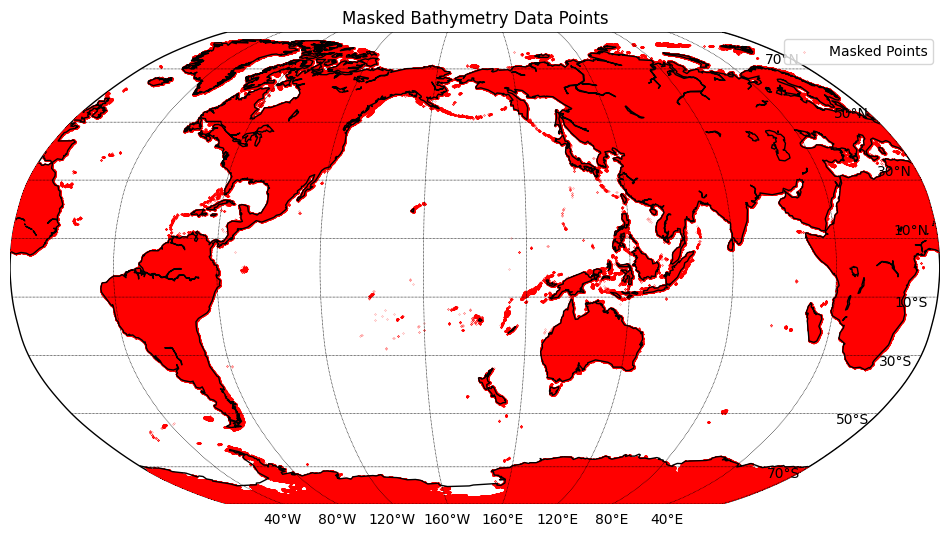

In [14]:
plot_model_mask(bathy_zx[:,1:10801].mask)

In [15]:
#Global variable 
#global_grid = False
print(global_grid)

True


In [91]:
#Global variable 
print(lonz[5398:5402]) #try chunk not crossing 180 degree to avoid interpolation error??
print(latz[2698:2702])
xChunkSz = 45
yChunkSz = 45
grid_sz = 1/30
lon_range = list(range(0, len(lonz), int(xChunkSz/grid_sz)))
##lon_range = list([x - 1 for x in lon_range]) # to not crossing 180 #slicing not include end
if len(lonz) not in lon_range:  # Ensure last element is included if it's not already
    lon_range.append(len(lonz))
print(lon_range)

lat_range = range(0, len(latz), int(yChunkSz/grid_sz))
lat_range = list([x + 1 if x==5400 else x for x in lat_range]) #lat length is 5401 not 5400
if len(latz) not in lat_range: 
    lat_range.append(len(latz))
print(lat_range)

lon_extend = range(0, len(lonzx), int(xChunkSz/grid_sz))
lon_extend = list([x + 1 for x in lon_extend]) 
#if len(lonzx) not in lon_extend:  
#    lon_extend.append(len(lonzx))
print(lon_extend)
print([lonzx[x] for x in lon_extend])
print(lonz[0], lonz[-1])


[179.96666463 179.99999797 180.0333313  180.06666463]
[-0.06666667 -0.03333333  0.          0.03333333]
[0, 1350, 2700, 4050, 5400, 6750, 8100, 9450, 10800]
[0, 1350, 2700, 4050, 5401]
[1, 1351, 2701, 4051, 5401, 6751, 8101, 9451, 10801]
[0.033333334014147384, 45.03333282527918, 90.03333231654422, 135.03333180780928, 180.03333129907432, 225.03333079033936, 270.0333302816044, 315.0333297728694, 360.03332926413447]
0.033333334014147384 359.999995931178


In [16]:
if global_grid:
    bathy = bathy_zx
    lonx = lonzx
    #lat_chunk = yChunkSz
    en_interpolate = True
else: 
    bathy = bathy_z
    lonx = lonz
    #lat_chunk = 180 #must sync with u, v
    en_interpolate = False
print(bathy.shape)    

(5401, 10802)


In [50]:
# Doing bathy_z need not interpolate, but lat_chunk must sync with doing u, v
# must rm -rf xx_chunks.zarr/
chunkz_file = 'tpxo9_chunks.zarr'
chunkz = tpxo2zarr(lonz, latz, bathy_z, 'h_amp', 'h_ph',  tpxo9_atlas_v5, 
                   xChunkSz, yChunkSz, grid_sz=1/30, chunk_file=chunkz_file, 
                   type=None, mode='write_chunk', global_grid=False, 
                   en_interpolate=False, interpolate_to=None)
print(chunkz)

0.033333334014147384 44.999999492322694 -90.0000035597249 -45.0333351145142 0
model type is:  z
45.03333282527918 89.99999898358773 -90.0000035597249 -45.0333351145142 1
model type is:  z
90.03333231654422 134.99999847485276 -90.0000035597249 -45.0333351145142 2
model type is:  z
135.03333180780928 179.9999979661178 -90.0000035597249 -45.0333351145142 3
model type is:  z
180.03333129907432 224.99999745738285 -90.0000035597249 -45.0333351145142 4
model type is:  z
225.03333079033936 269.9999969486479 -90.0000035597249 -45.0333351145142 5
model type is:  z
270.0333302816044 314.99999643991293 -90.0000035597249 -45.0333351145142 6
model type is:  z
315.0333297728694 359.999995931178 -90.0000035597249 -45.0333351145142 7
model type is:  z
0.033333334014147384 44.999999492322694 -45.00000177986245 -0.033333334651743485 8
model type is:  z
45.03333282527918 89.99999898358773 -45.00000177986245 -0.033333334651743485 9
model type is:  z
90.03333231654422 134.99999847485276 -45.00000177986245 -

In [ ]:
#Temporarily test, concate by lat axis, if no chunks in lon axis
# ds_combined = xr.concat([xr.open_zarr(chunkz_file, group=f"chunk_{i}") for i in range(chunkz)], dim='lat')
# chunk_size = 338
# ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
# ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)

# This approach assumes that each chunk has the same size, except perhaps the last one in each dimension. It takes the chunks, organizes them in their proper 2D sequence, and then concatenates them in the correct order.
num_lat_chunks = len(lat_range) - 1
num_lon_chunks = len(lon_range) - 1

# 1. Organize the chunks into a 2D matrix
chunks_matrix = [[xr.open_zarr(chunkz_file, group=f"chunk_{lat_idx*num_lon_chunks + lon_idx}") 
                  for lon_idx in range(num_lon_chunks)] 
                  for lat_idx in range(num_lat_chunks)]

# 2. Concatenate the chunks

# Concatenate chunks along the longitude for each latitude band
concat_along_lon = [xr.concat(lon_chunks, dim='lon') for lon_chunks in chunks_matrix]

# Now, concatenate the results along the latitude
ds_combined = xr.concat(concat_along_lon, dim='lat')

chunk_size = 338
ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)


In [59]:
dz = xr.open_zarr('tpxo9.zarr', chunks='auto', decode_times=False)
print(dz)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon           (lon) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    h_amp         (lat, lon, constituents) float64 dask.array<chunksize=(169, 338, 4), meta=np.ndarray>
    h_ph          (lat, lon, constituents) float64 dask.array<chunksize=(169, 338, 4), meta=np.ndarray>


In [60]:
#TPXO9_atlas_v5
ilon = 122.26672 #335
ilat = 23.76175 #30
grid_sz = 1/30

dsub = dz.sel(lon=slice(ilon, ilon+grid_sz), lat=slice(ilat, ilat+grid_sz))
print(dsub)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 1, lon: 1)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 23.77
  * lon           (lon) float64 122.3
Data variables:
    h_amp         (lat, lon, constituents) float64 dask.array<chunksize=(1, 1, 4), meta=np.ndarray>
    h_ph          (lat, lon, constituents) float64 dask.array<chunksize=(1, 1, 4), meta=np.ndarray>


In [61]:
start_date = datetime(2023, 7, 25)
end_date = datetime(2023, 7, 28)


tide_time, dtime = get_tide_time(start_date, end_date)
print(tide_time)

[11528.         11528.04166667 11528.08333333 11528.125
 11528.16666667 11528.20833333 11528.25       11528.29166667
 11528.33333333 11528.375      11528.41666667 11528.45833333
 11528.5        11528.54166667 11528.58333333 11528.625
 11528.66666667 11528.70833333 11528.75       11528.79166667
 11528.83333333 11528.875      11528.91666667 11528.95833333
 11529.         11529.04166667 11529.08333333 11529.125
 11529.16666667 11529.20833333 11529.25       11529.29166667
 11529.33333333 11529.375      11529.41666667 11529.45833333
 11529.5        11529.54166667 11529.58333333 11529.625
 11529.66666667 11529.70833333 11529.75       11529.79166667
 11529.83333333 11529.875      11529.91666667 11529.95833333
 11530.         11530.04166667 11530.08333333 11530.125
 11530.16666667 11530.20833333 11530.25       11530.29166667
 11530.33333333 11530.375      11530.41666667 11530.45833333
 11530.5        11530.54166667 11530.58333333 11530.625
 11530.66666667 11530.70833333 11530.75       11530.79

In [63]:
print(dsub["h_amp"].isel(lon=0, lat=0).values)
print(dsub["h_ph"].isel(lon=0, lat=0).values)
#print(c)

[0.03046309 0.15141995 0.05721888 0.17749648 0.08886507 0.4602532
 0.00223607 0.18709624 0.05200961 0.00360555 0.001      0.00141421
 0.01204159 0.00360555 0.00447214]
[ 66.80140842  77.79952929  95.01311547  97.44532534 289.04662886
 297.56720789  63.43495161 321.29236516 322.02839659 303.69006609
  -0.         224.99999966 265.23635719  33.69006859  26.56505089]


In [64]:
tide_level = get_tide(dsub['h_amp'].isel(lon=0, lat=0).values,
                      dsub['h_ph'].isel(lon=0, lat=0).values,
                      dsub.coords['constituents'].values, tide_time)

In [65]:
print(tide_level.data, max(tide_level.data), min(tide_level.data))

[  6.62611007  20.2963639   28.1105735   27.9606365   19.74070489
   5.45109202 -11.22423491 -25.84564972 -34.42519885 -34.53108119
 -25.92214166 -10.53841975   8.07407592  25.66333919  38.2417225
  42.94844814  38.68659369  26.41842325   8.9994027   -9.49240339
 -24.80315378 -33.62015018 -34.39541658 -27.62953117 -15.59156978
  -1.6415759   10.61316338  18.1422455   19.1760376   13.64418356
   3.24729648  -8.92916216 -19.22337332 -24.41511311 -22.62577859
 -13.809832     0.28063829  16.57770125  31.43303567  41.41866021
  44.06267449  38.41973078  25.35904324   7.44745013 -11.61856353
 -27.91947823 -38.29122119 -41.06517413 -36.36294249 -25.92305389
 -12.58621301   0.38913038  10.04524942  14.38051601  12.83479497
   6.46734948  -2.28654045 -10.27428584 -14.52385658 -13.09007682
  -5.58018663   6.76643202  21.39961448  35.03950498  44.37621209
  46.7856029   40.96372401  27.34255954   8.1279848  -13.13074937
 -32.36889307 -45.99038616 -51.69939371] 46.78560289547221 -51.69939371300065

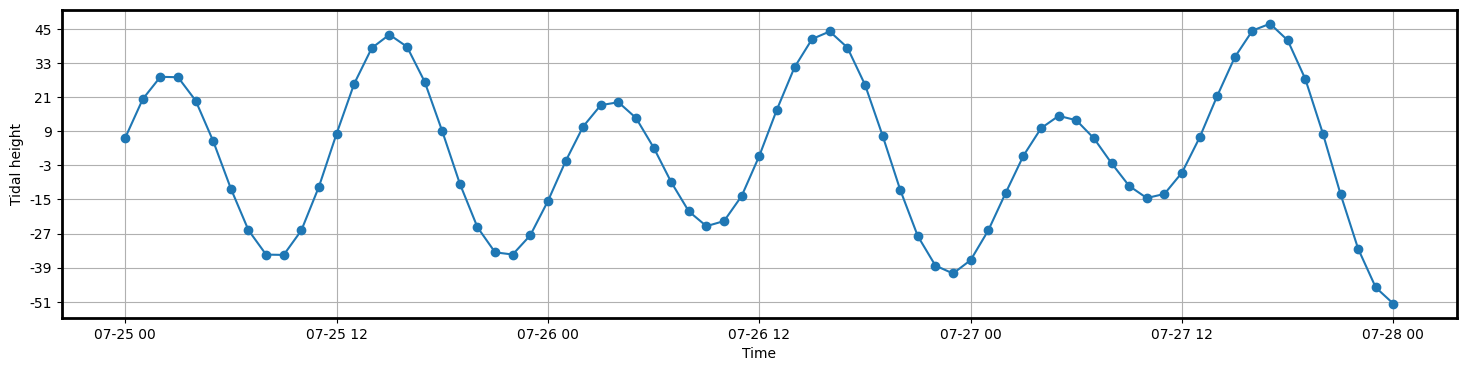

In [66]:
plot_tide_level(tide_level, dtime)

In [67]:

# Model parameters
tpxo_model_directory = '/home/bioer/python/tide/data_src'
tpxo_model_format = 'netcdf'
tpxo_compressed = False
tpxo_model_name = 'TPXO9-atlas-v5'

tpxo_curr_model = get_current_model(tpxo_model_name, tpxo_model_directory, tpxo_model_format, tpxo_compressed)

In [68]:
print(tpxo_curr_model)
print(tpxo_curr_model.grid_file)
print(tpxo_curr_model.model_file)

/home/bioer/python/tide/data_src/TPXO9_atlas_v5/grid_tpxo9_atlas_30_v5.nc
{'u': [PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_q1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_o1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_p1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_n2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data

In [69]:
#if tpxo_curr_model:
model_files= tpxo_curr_model.model_file["u"]
print(model_files)
model_file = pathlib.Path(model_files[0]).expanduser()
hcx, cons = read_netcdf_transport(model_file, variable="u", compressed=False)
print(hcx.shape)
print(hcx)
print(hcx.mask)
tmp_mask = np.copy(hcx.mask)
tmp_mask[hcx.data==0j] = True
print(np.where(tmp_mask))

[PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_q1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_o1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_p1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_n2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s1_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_s2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_k2_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_m4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/tide/data_src/TPXO9_atlas_v5/u_ms4_tpxo9_atlas_30_v5.nc'), PosixPath('/home/bioer/python/

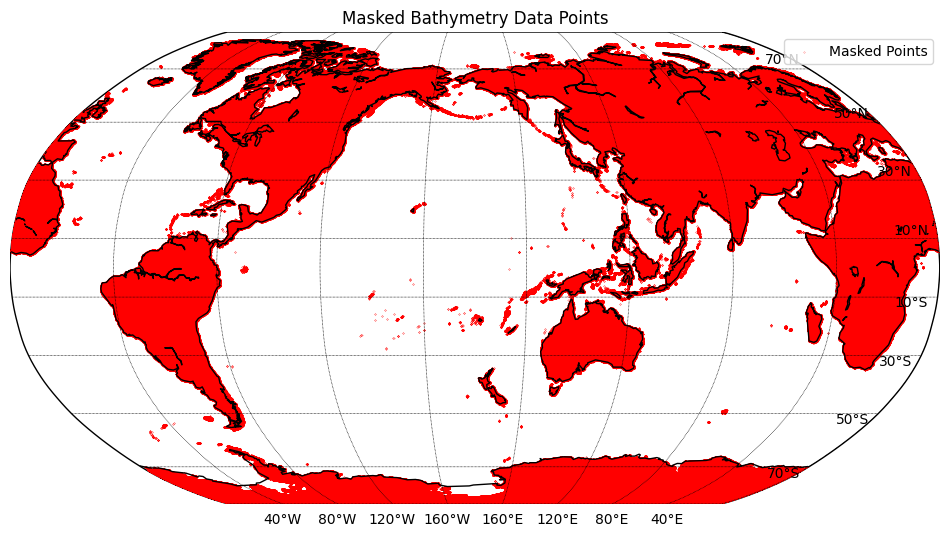

In [690]:
plot_model_mask(tmp_mask)

In [70]:
#read_netcdf_grid in ATLAS.py
#import netCDF4
fileID = netCDF4.Dataset(tpxo_curr_model.grid_file, 'r')
# read latitude and longitude at z-nodes
lonu = fileID.variables['lon_u'][:].copy()
latu = fileID.variables['lat_u'][:].copy()
print(lonu)
print(latu)
print(lonu.shape)
print(latu.shape)
nx = fileID.dimensions['nx'].size
ny = fileID.dimensions['ny'].size
print(ny, nx)
bathy_u = np.ma.zeros((ny,nx))
bathy_u.data[:,:] = fileID.variables['hu'][:,:].T
bathy_u.mask = (bathy_u.data == 0.0)

[1.66666675e-02 5.00000005e-02 8.33333334e-02 ... 3.59916663e+02
 3.59949996e+02 3.59983329e+02]
[-90.00000356 -89.96667023 -89.93333689 ...  89.93333689  89.96667023
  90.00000356]
(10800,)
(5401,)
5401 10800


In [74]:
# Adjust longitude and lat values as per convention
lonux = lonu #already in [0,360] # adjust_lon_lat(lonu, lonu)
    
# Determine if it's a global grid
dlon = lonux[1] - lonux[0]
#global_grid = np.isclose(lonux[-1] - lonux[0], 360.0 - dlon)
print(global_grid)
if global_grid:
    lonux = extend_array(lonux, dlon)
    bathy_ux = extend_matrix(bathy_u)
    
# create masks
bathy_ux.mask = (bathy_ux.data == 0)

#lon_grid, lat_grid = np.meshgrid(lonux, latu)
#Du = spline_2d(lonux, latu, bathy_ux, lon_grid, lat_grid, reducer=np.ceil, kx=1, ky=1)
print(bathy_ux.shape)


True
(5401, 10802)


In [582]:
#check value in bbox (-25, 25, -20, 30) => 335-340, 25-30 that has no values in u,v
pu = bathy_u[3450:3600, 10050:10200]
print(np.where(np.isnan(pu)))
print(np.where(pu.mask))
print(np.where(bathy_u.mask))
print(np.where(Du.mask))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))
(array([   0,    0,    0, ..., 5209, 5209, 5209]), array([   0,    1,    2, ..., 9823, 9824, 9825]))
(array([   0,    0,    0, ..., 5209, 5209, 5209]), array([   0,    1,    2, ..., 9824, 9825, 9826]))


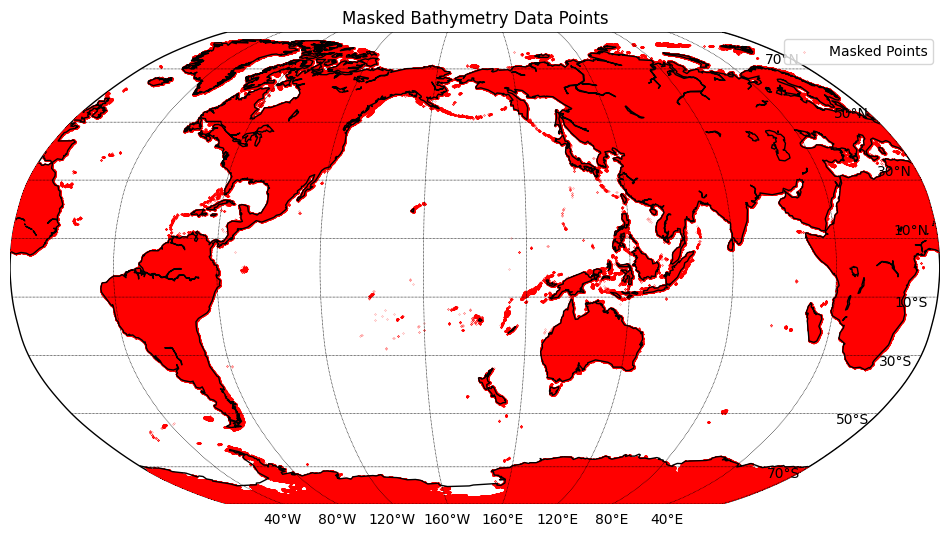

In [590]:
plot_model_mask(bathy_u.mask)

In [260]:
tolerance = 1e-9
def allIdentical(x, y, tolerance=1e-9):
    # Check if lon_u and lon_v are almost equal element-wise within the tolerance
    identicalx = np.allclose(x, y, atol=tolerance)

    if identicalx:
        print("The arrays are identical.")
        return None
    else:
        print("The arrays are not identical.")
        not_identical_mask = np.abs(x - y) > tolerance
        # Find the indices of elements that are not identical
        return np.where(not_identical_mask)

In [ ]:
nlonidx = allIdentical(lonz, lonu)
nlatidx = allIdentical(latz, latu)
print(lonz[nlonidx])
print(lonu[nlonidx])

In [71]:
fileID = netCDF4.Dataset(tpxo_curr_model.grid_file, 'r')
# read latitude and longitude at z-nodes
lonv = fileID.variables['lon_v'][:].copy()
latv = fileID.variables['lat_v'][:].copy()
print(lonv)
print(latv)
print(lonv.shape)
print(latv.shape)
nx = fileID.dimensions['nx'].size
ny = fileID.dimensions['ny'].size
print(ny, nx)
bathy_v = np.ma.zeros((ny,nx))
bathy_v.data[:,:] = fileID.variables['hv'][:,:].T
bathy_v.mask = (bathy_v.data == 0.0)

[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]
[-90.01667023 -89.98333689 -89.95000356 ...  89.91667022  89.95000356
  89.98333689]
(10800,)
(5401,)
5401 10800


In [ ]:
nlonidx = allIdentical(lonu, lonv)
nlatidx = allIdentical(latu, latv)
print(lonu[nlonidx])
print(lonv[nlonidx])
print("--------------------")
print(latu[nlatidx])
print(latv[nlatidx])


In [ ]:
nlonidx = allIdentical(lonz, lonv)
nlatidx = allIdentical(latz, latv)
print(lonz[nlonidx])
print(lonv[nlonidx])
print("--------------------")
print(latz[nlatidx])
print(latv[nlatidx])

In [77]:
# must rm -rf xx_chunks.zarr/
# global_grid = False
if global_grid:
    bathy = bathy_ux
    lonx = lonux
    #lat_chunk = 45
    en_interpolate = True
else: 
    bathy = bathy_u
    lonx = lonu
    #lat_chunk = 180
    en_interpolate = False

print(global_grid)
print(en_interpolate)
print(lonx)

True
True
[-1.66666654e-02  1.66666675e-02  5.00000005e-02 ...  3.59949996e+02
  3.59983329e+02  3.60016663e+02]


In [83]:
# must rm -rf xx_chunks.zarr/
# check ['q1', 'o1', 'p1', 'k1', 'n2', 'm2', 's1', 's2', 'k2', 'm4', 'ms4', 'mn4', '2n2', 'mf', 'mm']
# cp -R tpxo9_chunkz.zarr/ tpxo9_chunks.zarr
chunk_file = 'tpxo9_chunks.zarr'
chunku = tpxo2zarr(lonx, latu, bathy, 'u_amp', 'u_ph',  tpxo_curr_model, 
                   xChunkSz, yChunkSz, grid_sz=1/30, 
                   chunk_file=chunk_file, type='u', mode="append_chunk", global_grid=global_grid,
                   en_interpolate=en_interpolate, interpolate_to=(lonz, latz, bathy_z))
print(chunku)

0.016666667535901077 44.98333282584445 -90.0000035597249 -45.0333351145142 0
model type is:  u
Interpolate to write:  0.033333334014147384 44.999999492322694 -90.0000035597249 -45.0333351145142
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
45.01666615880094 89.98333231710949 -90.0000035597249 -45.0333351145142 1
model type is:  u
Interpolate to write:  45.03333282527918 89.99999898358773 -90.0000035597249 -45.0333351145142
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350)
extrapolate:  (1350, 1350

IndexError: index 10802 is out of bounds for axis 0 with size 10802

In [ ]:
# Adjust longitude and lat values as per convention
lonvx = lonv #already in [0,360] # adjust_lon_lat(lonv, lonv)
    
# Determine if it's a global grid
dlon = lonvx[1] - lonvx[0]
print(global_grid)
#global_grid = np.isclose(lonvx[-1] - lonvx[0], 360.0 - dlon)
if global_grid:
    lonvx = extend_array(lonvx, dlon)
    bathy_vx = extend_matrix(bathy_v)
    
# create masks
bathy_vx.mask = (bathy_vx.data == 0)

#lon_grid, lat_grid = np.meshgrid(lonvx, latv)
#Dv = spline_2d(lonvx, latv, bathy_vx, lon_grid, lat_grid, reducer=np.ceil, kx=1, ky=1)
print(bathy_vx.shape)
#print(Dv)

[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [4216.5634765625 4216.5712890625 4216.5791015625 ... 4216.5390625
  4216.546875 4216.55517578125]
 [4216.154296875 4216.15771484375 4216.1611328125 ... 4216.1435546875
  4216.1474609375 4216.150390625]
 [4215.673828125 4215.6748046875 4215.67578125 ... 4215.67138671875
  4215.67236328125 4215.6728515625]]
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [4216.55517578125 4216.5634765625 4216.5712890625 ... 4216.546875
  4216.55517578125 4216.5634765625]
 [4216.150390625 4216.154296875 4216.15771484375 ... 4216.1474609375
  4216.150390625 4216.154296875]
 [4215.6728515625 4215.673828125 4215.6748046875 ... 4215.67236328125
  4215.6728515625 4215.673828125]]


In [579]:
print(np.where(np.isnan(bathy_v)))
print(np.where(np.isnan(Dv)))

(array([], dtype=int64), array([], dtype=int64))
(array([], dtype=int64), array([], dtype=int64))


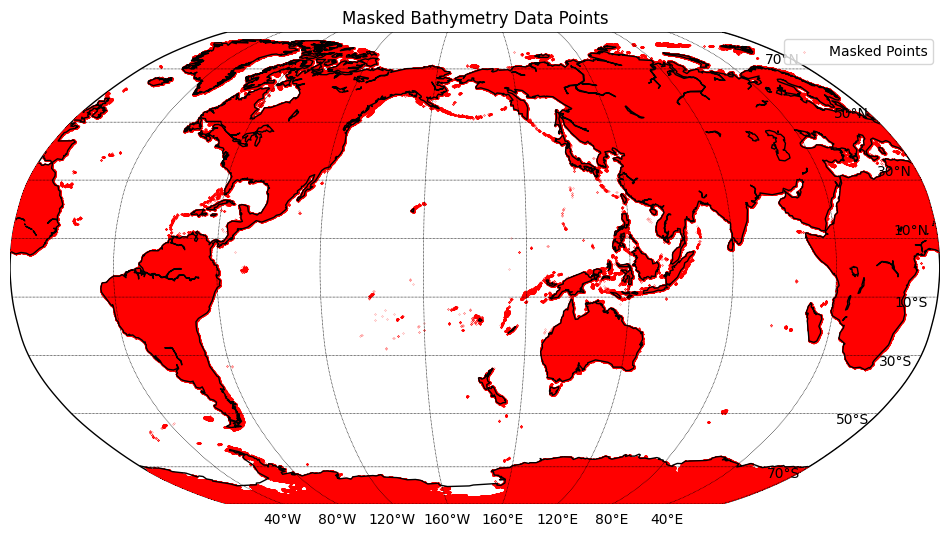

In [592]:
plot_model_mask(Dv[:,1:10801].mask)

In [ ]:
# must rm -rf xx_chunks.zarr/
# global_grid = False
if global_grid:
    bathy = bathy_vx
    lonx = lonvx
    #lat_chunk = 45
    en_interpolate = True
else: 
    bathy = bathy_v
    lonx = lonv
    #lat_chunk = 180
    en_interpolate = False

print(en_interpolate)
print(lonx)

[3.33333340e-02 6.66666670e-02 9.99999999e-02 ... 3.59933329e+02
 3.59966663e+02 3.59999996e+02]


In [ ]:
#chunk_file = 'tpxo9_chunks.zarr'
chunkv = tpxo2zarr(lonx, latv, bathy, 'v_amp', 'v_ph',  tpxo_curr_model, 
                   xChunkSz, yChunkSz, grid_sz=1/30, 
                   chunk_file=chunk_file, type='v', mode="append_chunk", global_grid=global_grid, 
                   en_interpolate=en_interpolate, interpolate_to=(lonz, latz, bathy_z))
print(chunkv)

0 10800 0 5401
model type is:  v
Force use lonz, latz to append chunk
1


In [ ]:
#ds_combined = xr.concat([xr.open_zarr(chunk_file, group=f"chunk_{i}") for i in range(chunkv)], dim='lat')
#chunk_size = 338
#ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
#ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)


# This approach assumes that each chunk has the same size, except perhaps the last one in each dimension. It takes the chunks, organizes them in their proper 2D sequence, and then concatenates them in the correct order.
num_lat_chunks = len(lat_range) - 1
num_lon_chunks = len(lon_range) - 1

# 1. Organize the chunks into a 2D matrix
chunks_matrix = [[xr.open_zarr(chunk_file, group=f"chunk_{lat_idx*num_lon_chunks + lon_idx}") 
                  for lon_idx in range(num_lon_chunks)] 
                  for lat_idx in range(num_lat_chunks)]

# 2. Concatenate the chunks

# Concatenate chunks along the longitude for each latitude band
concat_along_lon = [xr.concat(lon_chunks, dim='lon') for lon_chunks in chunks_matrix]

# Now, concatenate the results along the latitude
ds_combined = xr.concat(concat_along_lon, dim='lat')

chunk_size = 338
ds_rechunked = ds_combined.chunk({'lat': chunk_size, 'lon': chunk_size, 'constituents': -1})
ds_rechunked.to_zarr('tpxo9.zarr', mode='w', safe_chunks=False)

In [22]:
dz = xr.open_zarr('tpxo9.zarr', chunks='auto', decode_times=False)
print(dz)

<xarray.Dataset>
Dimensions:       (constituents: 15, lat: 5401, lon: 10800)
Coordinates:
  * constituents  (constituents) <U3 'q1' 'o1' 'p1' 'k1' ... '2n2' 'mf' 'mm'
  * lat           (lat) float64 -90.0 -89.97 -89.93 -89.9 ... 89.93 89.97 90.0
  * lon           (lon) float64 0.03333 0.06667 0.1 0.1333 ... 359.9 360.0 360.0
Data variables:
    h_amp         (lat, lon, constituents) float64 dask.array<chunksize=(338, 675, 2), meta=np.ndarray>
    h_ph          (lat, lon, constituents) float64 dask.array<chunksize=(338, 675, 2), meta=np.ndarray>
    u_amp         (lat, lon, constituents) float64 dask.array<chunksize=(338, 675, 2), meta=np.ndarray>
    u_ph          (lat, lon, constituents) float64 dask.array<chunksize=(338, 675, 2), meta=np.ndarray>
    v_amp         (lat, lon, constituents) float64 dask.array<chunksize=(338, 675, 2), meta=np.ndarray>
    v_ph          (lat, lon, constituents) float64 dask.array<chunksize=(338, 675, 2), meta=np.ndarray>


In [23]:
x0, y0, x1, y1 = 118.0, 20.0, 129.75, 31.25 
#x0, y0, x1, y1 = 122.26672, 23.76175, 129.75, 31.25 #123.5, 28 #to test v is empty bug 
#x0, y0, x1, y1 = 123.75, 23.76175, 129.75, 31.25
grid_sz = 1/30
uvsub = dz.sel(lon=slice(x0-grid_sz, x1+grid_sz), lat=slice(y0-grid_sz, y1+grid_sz))
#print(uvsub['u_amp'].values)
#print(uvsub['u_ph'].values)


In [26]:
tide_curr = get_current_zarr(uvsub, tide_time[0:2])
print(tide_curr)

{'u': masked_array(
  data=[[[--, --],
         [--, --],
         [--, --],
         ...,
         [--, --],
         [--, --],
         [--, --]],

        [[--, --],
         [--, --],
         [--, --],
         ...,
         [--, --],
         [--, --],
         [--, --]],

        [[--, --],
         [--, --],
         [--, --],
         ...,
         [--, --],
         [--, --],
         [--, --]],

        ...,

        [[--, --],
         [--, --],
         [--, --],
         ...,
         [-1001.7172898331705, -1570.0729717574166],
         [-911.9137155180871, -1484.06674556955],
         [-818.7085953959654, -1394.6157794842616]],

        [[--, --],
         [--, --],
         [--, --],
         ...,
         [-1023.2622928303334, -1600.7682282377257],
         [-948.1025171253971, -1514.4161069572635],
         [-860.056305326802, -1416.7405047696034]],

        [[--, --],
         [--, --],
         [--, --],
         ...,
         [-1000.4060888788662, -1603.96867833171

In [27]:
gtide = tide_curr
dsel = uvsub
# Set the time index (0 to 23)
t = 0
nx = dsel.coords['lon'].size
ny = dsel.coords['lat'].size
print(ny, nx)
glon, glat = np.meshgrid(dsel.coords['lon'].values, dsel.coords['lat'].values)

# Reshape u and v to 2D
u0 = gtide['u'][:,:,t] #.reshape(ny, nx)
v0 = gtide['v'][:,:,t] #.reshape(ny, nx)

# Create a grid of indices for subsetting
# ny, nx = np.shape(lon)
X, Y = np.meshgrid(np.arange(nx), np.arange(ny))

# Calculate magnitude of the current
magnitude = np.sqrt(u0**2 + v0**2)
print(magnitude)
print(u0)
print(v0)
# Normalize the arrows to create a uniform arrow size across the plot
u = u0/magnitude
v = v0/magnitude



n = 5
mask = (X % n == 0) & (Y % n == 0)

x = glon[mask]
y = glat[mask]
u = u[mask]
v = v[mask]
mag = magnitude[mask]*0.01

340 354
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... 1044.2380186583089 1018.1416901483731 1019.3921589189198]
 [-- -- -- ... 1036.1912855548767 999.6703716904947 985.5375332234973]
 [-- -- -- ... 1001.5730890117269 968.8578189471895 948.0502256765769]]
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... -1001.7172898331705 -911.9137155180871 -818.7085953959654]
 [-- -- -- ... -1023.2622928303334 -948.1025171253971 -860.056305326802]
 [-- -- -- ... -1000.4060888788662 -950.650019576511 -880.6821014897425]]
[[-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 [-- -- -- ... -- -- --]
 ...
 [-- -- -- ... 294.9500141731113 452.79783200472946 607.3521297321198]
 [-- -- -- ... 163.1767763239518 316.9265988463228 481.2352658106708]
 [-- -- -- ... 48.33539041512762 186.94922737011854 350.99610613369975]]


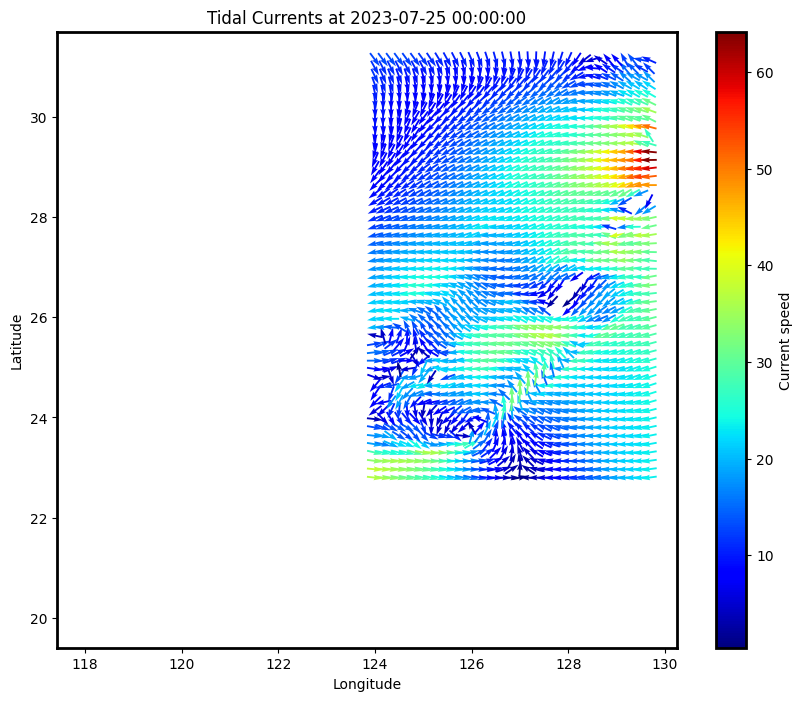

In [28]:
plot_current(x, y, u, v, mag, dtime[0])

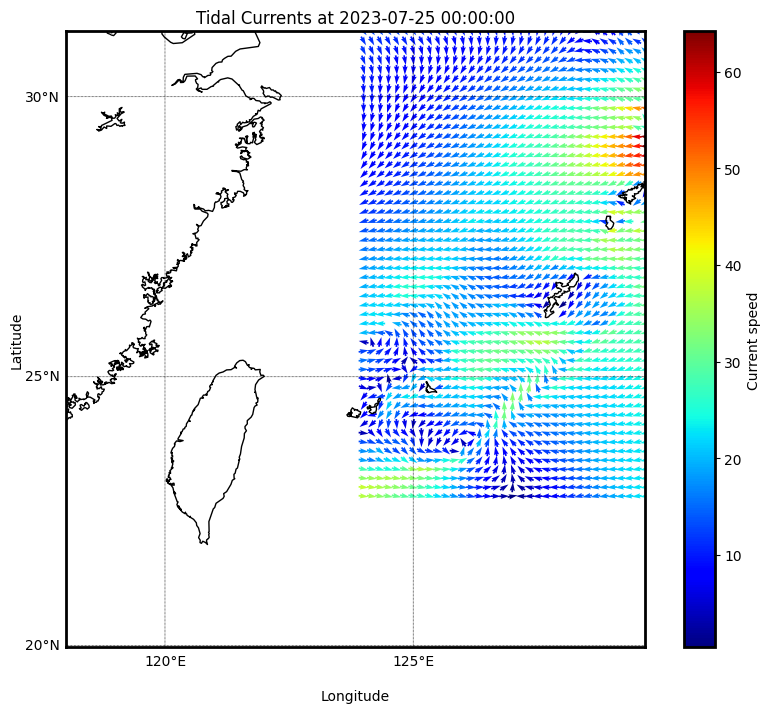

In [29]:
plot_current_map(x, y, u, v, mag, dtime[0])

In [339]:
#just debugging...
subset_lon_values = uvsub.coords['lon'].values
subset_lat_values = uvsub.coords['lat'].values

# Get the original lon and lat values
original_lon_values = dz.coords['lon'].values
original_lat_values = dz.coords['lat'].values

# Find the start and end indices of the subset lon and lat in the original lon and lat
start_lon = np.where(original_lon_values == subset_lon_values[0])[0][0]
end_lon = np.where(original_lon_values == subset_lon_values[-1])[0][0] + 1 # +1 for slice not include end

start_lat = np.where(original_lat_values == subset_lat_values[0])[0][0]
end_lat = np.where(original_lat_values == subset_lat_values[-1])[0][0] + 1
print(start_lon, end_lon, start_lat, end_lat)
#print(bathy_v[start_lat:end_lat, start_lon:end_lon])
print(uvsub["v_amp"].values)
filled = uvsub.interpolate_na(['lon','lat'], method="spline")
print(filled["v_amp"].values)

3644 3766 3374 3586


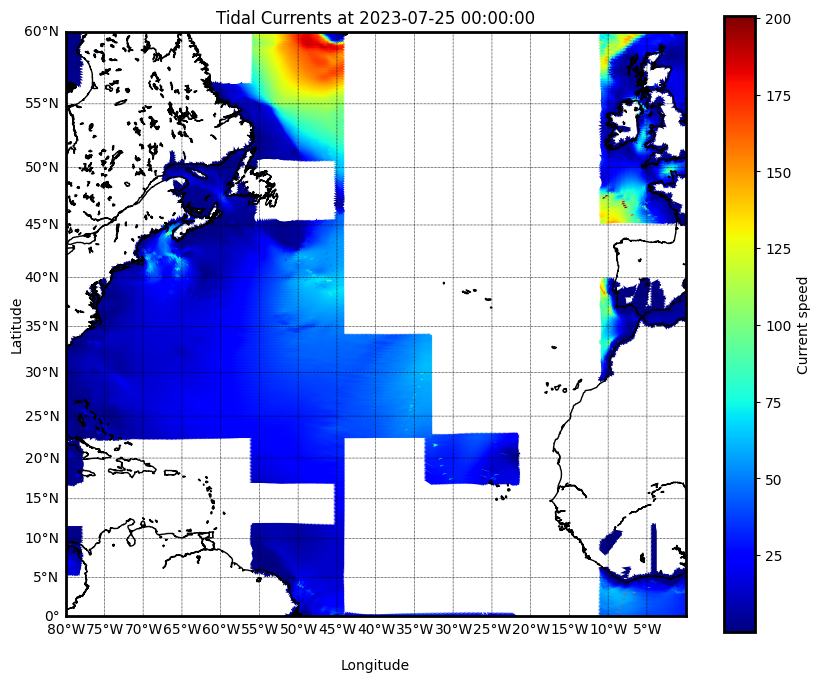

In [557]:
#North Atlantic
x1, y1, u1, v1, mag1 = get_current_map(280, 0, 360, 60, dz, tide_time[0:1], mask_grid=5)
plot_current_map(x1, y1, u1, v1, mag1, dtime[0])

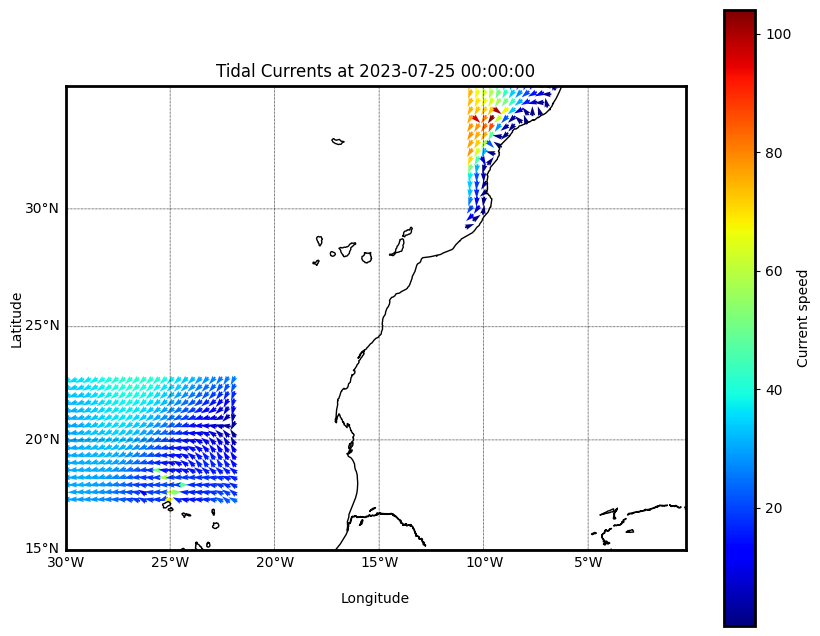

In [558]:
x1t, y1t, u1t, v1t, mag1t = get_current_map(330, 15, 359.9, 35, dz, tide_time[0:1], mask_grid=10)
plot_current_map(x1t, y1t, u1t, v1t, mag1t, dtime[0])

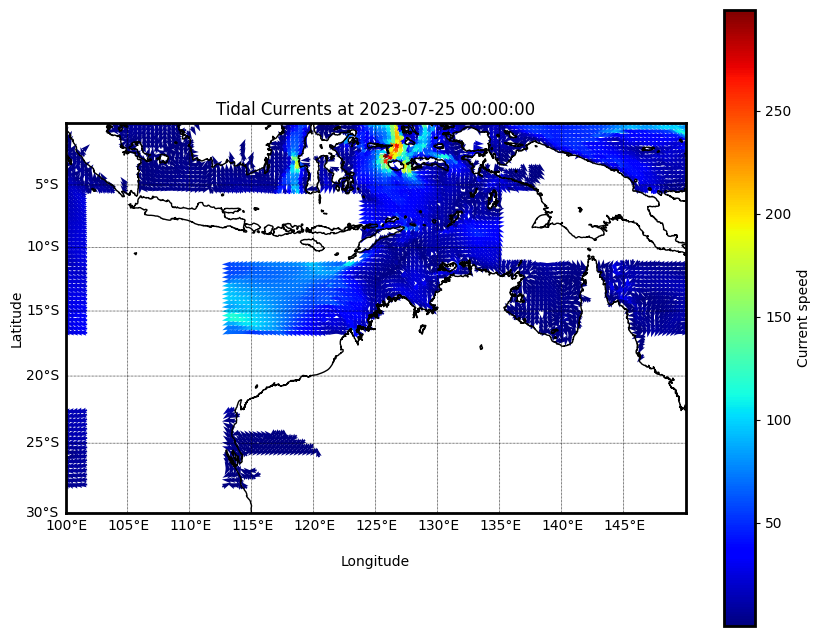

In [559]:
#Indian Ocean
x2, y2, u2, v2, mag2 = get_current_map(100, -30, 150, 0, dz, tide_time[0:1], mask_grid=10)
plot_current_map(x2, y2, u2, v2, mag2, dtime[0])